In [23]:
import pandas as pd 
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 

q = pd.read_csv("../data/dim_quote.csv")

# convert the target to a binary variable
q['status'] = q['status'].apply(lambda x: 1 if x == 'won' else 0)

# Filter to 1 product
q = q[q['product_id'] == 1]

In [24]:
q.head(5)

,quote_id,quote_date,account_id,sales_rep_id,product_id,quantity,status,region,close_date,days_to_close,list_price,unit_price,margin,region_bias,prediction
2,3,2024-10-03,54369,1,1,101,0,North,2024-10-22,19,250.0,153.80,61.521960,-1.828855,42.879688
3,4,2024-03-19,11367,4,1,324,0,East,2024-03-23,4,250.0,177.32,70.926289,7.967555,46.647765
40,41,2024-04-22,29472,5,1,215,0,North,2024-05-19,27,250.0,125.45,50.181544,-1.828855,38.060353
55,57,2024-09-26,77025,3,1,100,0,South,2024-10-16,20,250.0,155.10,62.038732,-9.068150,37.572954
56,58,2024-10-16,35977,9,1,44,1,West,2024-11-12,27,250.0,152.07,60.826846,14.897970,69.670733


In [25]:
# Create a prediction pipeline for probabilty to win a quote
np.random.seed(42)

# Define the numerical, categorical, and target
num_attribs = ['quantity', 'margin']
cat_attribs = ['region']
x_attribs = num_attribs + cat_attribs
y_attribs = ['status']

# Split training and test data - stratified by the target
from sklearn.model_selection import train_test_split
train, test = train_test_split(q, test_size=0.2, stratify=q['status'])

# Create a pipeline to preprocess the data
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log_scaler', FunctionTransformer(np.log1p)),
    ('std_scaler', StandardScaler())    
])

X_pipeline_standard = ColumnTransformer([
    ('quantity', num_pipeline, ['quantity']),
    ('cat', TargetEncoder(), cat_attribs),
    ('pass', StandardScaler(), ['margin'])
], remainder='drop')

# Create the model
model = RandomForestClassifier()

# Create the full pipeline
full_pipeline = Pipeline([
    ('preprocess', X_pipeline_standard),
    ('model', model)
])

param_grid = {}
# Create the gridsearch
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=5, 
    n_jobs=-1,
    scoring='f1', # Use ROC AUC as the scoring metric for imbalanced data
    refit=True
)

# Fit the gridsearch
grid_search.fit(test, test['status'])
test["status_prediction"] = grid_search.predict(test)
q["status_prediction"] = grid_search.predict(q)

In [26]:
# Provide Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(test['status'], test['status_prediction'])

array([[1562,    0],
       [   1,  381]])

In [27]:
confusion_matrix(q['status'], q['status_prediction'])

array([[7390,  418],
       [1329,  582]])

In [28]:
# print accuracy
from sklearn.metrics import accuracy_score
accuracy_score(q['status'], q['status_prediction'])

0.8202489968103714

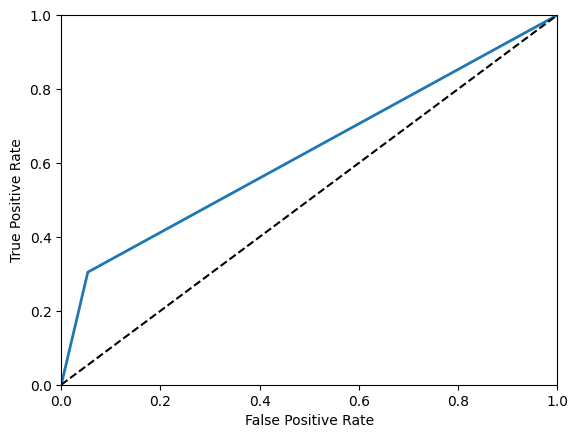

In [29]:
# Create an ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(q['status'], q['status_prediction'])

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [30]:
# get feature names
feat_names = []
steps = grid_search.best_estimator_.named_steps['preprocess'].transformers_
for step in steps[:-1]:
    feat_names += step[2]

# get feature importances
importances = grid_search.best_estimator_.named_steps['model'].feature_importances_

# zip the feature names and importances
feat_importances = list(zip(feat_names, importances))
feat_importances = sorted(feat_importances, key=lambda x: x[1], reverse=True)
feat_importances


[('margin', np.float64(0.5339056706810409)),
 ('quantity', np.float64(0.43330625968720027)),
 ('region', np.float64(0.032788069631758975))]

In [31]:
# plot 
import matplotlib.pyplot as plt
import plotly.express as px

px.scatter(data_frame=q, x='quantity', y='margin', color='status', log_x=True, opacity=0.3)

In [32]:
# create a cross join of original dataset to simulate all possible combinations of quantity and margin
array_df = pd.DataFrame(np.linspace(1, 100, 100), columns=['linspace_value'])
array_df['key'] = 1
q['key'] = 1
cross_df = pd.merge(q, array_df, on='key')
cross_df = cross_df.drop(columns=['key'])
cross_df['margin_true'] = cross_df['margin']
cross_df['margin'] = cross_df['linspace_value']

# Predict the status for all possible combinations of quantity and margin
cross_df['status_prediction'] = grid_search.predict(cross_df)
cross_df['status_prediction_prob'] = grid_search.predict_proba(cross_df)[:, 1]

# Multiply Probability & Margin to find the expected value
cross_df['target_price'] = cross_df['status_prediction_prob'] * cross_df['margin_true']

# identify the maximum expected value for each quote
cross_df["target_price_best"]= cross_df.groupby('quote_id')['target_price'].transform("max")

# filter to only the best expected value
cross_df["best"] = (cross_df['target_price'] == cross_df['target_price_best']) * 1

# save list of quotes 
cross_df[['quote_id', 'product_id', 'margin', 'target_price', 'best']].to_csv("dim_quote_probability.csv", index=False)

In [33]:
# show plot of single quote with all possible combinations of quantity and 
quote = cross_df['quote_id'].sample(1).values[0]
plt_df = cross_df[cross_df['quote_id'] == quote]
px.scatter(data_frame=plt_df, x='margin', y='target_price', opacity=0.3)